# Определение возраста покупателя

#### Тема проекта:
- Определить возраст покупателя

#### Цель:
- Построить модель для определения приблизительного возраста человека

#### Поставленные задачи:
- Исследовать предоставленные данные;
- Для обучения использовать нейронные сети;
- Получить значение MAE не больше 8.

#### Краткий план работы:
- [Шаг 1. Исследовательский анализ данных](#Шаг-1.-Исследовательский-анализ-данных)
  - [1.1. Проверка размера выборки](#1.1.-Проверка-размера-выборки)
  - [1.2. Распределение возраста в выборке](#1.2.-Распределение-возраста-в-выборке)
  - [1.3. Исследование изображений датасета](#1.3.-Исследование-изображений-датасета)

- [Шаг 2. Обучение модели](#Шаг-2.-Обучение-модели)
  - [2.1. Код для обучения модели](#2.1.-Код-для-обучения-модели)
  - [2.2. Результат вывода модели](#2.2.-Результат-вывода-модели)
  - [2.3. Анализ обученной модели](#2.3.-Анализ-обученной-модели)

#### Вывод:
- Исследованы предоставленные данные;
- На тестовой выборке удалось достигнуть значения MAE не больше 8.

**Статус проекта**: проект завершён.

**Используемые библиотеки**: *numpy*, *pandas*, *matplotlib*, *seaborn*, *tensorflow.keras*

**Источник данных**: [курс Data Science от Яндекс.Практикум](https://praktikum.yandex.ru/profile/data-scientist/)

In [1]:
# импорт библиотек и функция для дальнейшей работы
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

## Шаг 1. Исследовательский анализ данных

Данный шаг состоит из следующих этапов:
- [1.1. Проверка размера выборки](#1.1.-Проверка-размера-выборки)
- [1.2. Распределение возраста в выборке](#1.2.-Распределение-возраста-в-выборке)
- [1.3. Исследование изображений датасета](#1.3.-Исследование-изображений-датасета)

### 1.1. Проверка размера выборки

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
print('Размер выборки:', labels.shape[0])
print('Количество дубликатов:', labels['file_name'].duplicated().sum())
print()
print(labels.info())
labels.head()

Размер выборки: 7591
Количество дубликатов: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB
None


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


- Размер выборки - 7591 наблюдений (фотографий с лицами).
- Пропуски в данных отсутствуют.
- Задублированных *file_name* (номера фотографий) нет.

### 1.2. Распределение возраста в выборке

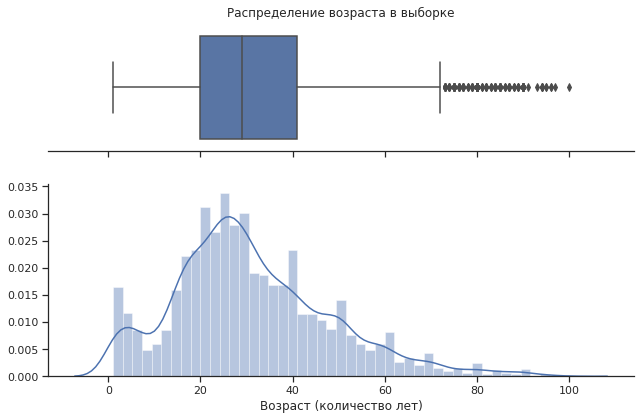

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [3]:
# значения возраста
x = labels['real_age']

# настройка сабплотов
sns.set(style="ticks")
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.4, .6)})
# настройка размера
f.set_size_inches(10.5, 6.5, forward=True)

# построение графиков
sns.boxplot(x, ax=ax_box).set_title('Распределение возраста в выборке')
sns.distplot(x, ax=ax_hist).set(xlabel='Возраст (количество лет)')

ax_box.set(yticks=[])
ax_box.set(xlabel=None)
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)
plt.show()

labels[['real_age']].describe()

- Выборочные данные распределены не нормально. Распределение значений скошено вправо в сторону бóльших значений, т. е. более старшего возраста.
- Тем старше возраст, тем меньше фотографий. Это можно объяснить и тем, что, например, людей 100-летнего возраста не так много, поэтому нет возможности сделать много фотографий.
- В основном выборка содержит фотографии **относительно молодых** людей - 75% фотографии людей **до 41 года** включительно.
- **Минимальный** возраст человека на фотографии - **1 год**; **максимальный** - **100 лет**.
- На гистограмме наблюдается некоторый провал в количестве наблюдений для возраста, соответствующего детско-подростковому.

In [4]:
# вывод значений для "провала" на гистограмме
# количество фотографий по возрасту до 20 лет
labels['real_age'].value_counts().sort_index().head(20)

1     149
2      88
3      25
4     101
5      87
6      68
7      67
8      44
9      34
10     45
11     51
12     56
13     79
14    125
15    128
16    193
17    163
18    193
19    180
20    178
Name: real_age, dtype: int64

- Дополнительно убедились в том, что фотографий для 5-13 лет действительно меньше. 

### 1.3. Исследование изображений датасета

In [5]:
SEED = 12345
# создание загрузчика
datagen = ImageDataGenerator(rescale=1./255)
# извлечение данных из папки
datagen_flow = datagen.flow_from_directory('/datasets/faces', 
                                           target_size=(150, 150), 
                                           batch_size=15, # выберем размер батча 15 картинок
                                           class_mode='sparse',
                                           seed=SEED)

Found 7591 images belonging to 1 classes.


- В датасете 7591 изображений, которые лежат в одной папке `final_files`.

In [6]:
# получение признаков и меток батча
features, target = next(datagen_flow)
print(target.shape)
print(features.shape)

(15,)
(15, 150, 150, 3)


Переменная *target* - это количество меток для батча. Одна картинка - одна метка.

Переменная *features* - это четырёхмерный тензор, в котором:
 - 15 изображений (`batch_size=15`)
 - размер изобрадения 150x150 (`target_size=(150, 150)`)
 - с тремя цветовыми каналами

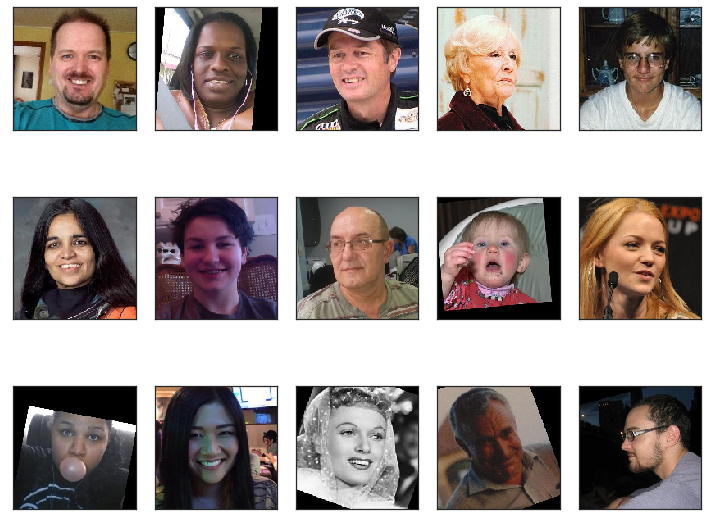

In [7]:
# вывод 15 фотографий
fig = plt.figure(figsize=(10,10))
for i in range(15):
    fig.add_subplot(3, 5, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

- На фотографиях изображены люди разных возрастов.
- Заметно, что некоторые фотографии были повёрнуты и отцентрированы (по бокам виден чёрный фон).

### Вывод
- Мы получили представления о размере датасета - 7591 фотографий.  
- В основном в данных содержатся фотографии **относительно молодых** людей **до 41 года** включительно.
- В распределении мы обнаружили, что по **детско-подростковому** возрасту фотографий меньше, чем, например, для возраста 30-35 лет.
- Данные смещены вправо, т. е. для каждой группы людей **более старшего возраста** фотографий становится всё меньше и меньше. Это можно объяснить и тем, что, например, людей 100-летнего возраста не так много, поэтому нет возможности сделать много фотографий.
- Возможно, это может повлиять на качество определения возраста для людей детско-подросткового возраста и людей старше 41 года - т. к. данных меньше, то возраст будет определяться хуже и менее точно.

## Шаг 2. Обучение модели

Данный шаг состоит из следующих этапов:
- [2.1. Код для обучения модели](#2.1.-Код-для-обучения-модели)
- [2.2. Результат вывода модели](#2.2.-Результат-вывода-модели)
- [2.3. Анализ обученной модели](#2.3.-Анализ-обученной-модели)

### 2.1. Код для обучения модели

```python
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow

def create_model(input_shape):
    backbone = ResNet50(weights='imagenet',
                        input_shape=input_shape,
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model
```

### 2.2. Результат вывода модели

```
Train for 356 steps, validate for 119 steps
Epoch 1/20
2020-10-28 18:30:22.744942: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2020-10-28 18:30:23.192092: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 103s - loss: 203.0385 - mae: 10.8739 - val_loss: 293.8645 - val_mae: 12.8330
Epoch 2/20
356/356 - 43s - loss: 136.7750 - mae: 8.9383 - val_loss: 334.2665 - val_mae: 13.6314
Epoch 3/20
356/356 - 43s - loss: 112.3798 - mae: 8.1051 - val_loss: 137.2807 - val_mae: 8.8884
Epoch 4/20
356/356 - 43s - loss: 91.3486 - mae: 7.3287 - val_loss: 226.6359 - val_mae: 11.4780
Epoch 5/20
356/356 - 43s - loss: 82.1441 - mae: 6.8886 - val_loss: 95.1050 - val_mae: 7.4587
Epoch 6/20
356/356 - 43s - loss: 67.6347 - mae: 6.3009 - val_loss: 206.3380 - val_mae: 9.9125
Epoch 7/20
356/356 - 43s - loss: 60.8816 - mae: 6.0017 - val_loss: 204.9204 - val_mae: 10.1222
Epoch 8/20
356/356 - 43s - loss: 52.9809 - mae: 5.5706 - val_loss: 111.1738 - val_mae: 7.9847
Epoch 9/20
356/356 - 43s - loss: 44.5622 - mae: 5.1535 - val_loss: 92.9350 - val_mae: 7.1762
Epoch 10/20
356/356 - 43s - loss: 37.7872 - mae: 4.7277 - val_loss: 88.3768 - val_mae: 7.2135
Epoch 11/20
356/356 - 43s - loss: 32.3784 - mae: 4.3533 - val_loss: 93.2735 - val_mae: 7.4204
Epoch 12/20
356/356 - 43s - loss: 27.0656 - mae: 4.0196 - val_loss: 91.4061 - val_mae: 7.1279
Epoch 13/20
356/356 - 43s - loss: 25.3203 - mae: 3.8816 - val_loss: 83.6844 - val_mae: 6.8922
Epoch 14/20
356/356 - 43s - loss: 22.9779 - mae: 3.6827 - val_loss: 91.7456 - val_mae: 7.4043
Epoch 15/20
356/356 - 43s - loss: 24.3332 - mae: 3.7818 - val_loss: 88.6444 - val_mae: 7.0897
Epoch 16/20
356/356 - 42s - loss: 27.6509 - mae: 3.9658 - val_loss: 118.4904 - val_mae: 8.3564
Epoch 17/20
356/356 - 43s - loss: 23.5135 - mae: 3.7600 - val_loss: 86.4101 - val_mae: 6.9535
Epoch 18/20
356/356 - 42s - loss: 19.8122 - mae: 3.4351 - val_loss: 76.2178 - val_mae: 6.5239
Epoch 19/20
356/356 - 43s - loss: 16.3459 - mae: 3.1067 - val_loss: 91.5621 - val_mae: 7.1974
Epoch 20/20
356/356 - 43s - loss: 14.1279 - mae: 2.9126 - val_loss: 77.7901 - val_mae: 6.6537
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 10s - loss: 77.7901 - mae: 6.6537
Test MAE: 6.6537

```

### 2.3. Анализ обученной модели

- Нам удалось достичь результата **MAE 6.6537**, т. е. в среднем при определении возраста наша модель ошибается на 6-7 лет.

Подробнее про обучение модели:
- Для обучения мы использовали архитектуру **ResNet50**. Для адаптации к нашей модели мы сконструировали самостоятельно верхний слой.
- В качестве алгоритма обучения нейронной сети был выбран **Adam** с заданным *learning rate* 0.005.
- В качестве **функции потерь** для задачи регрессии выбрана **MSE**, т. к. обычно нейронные сети с функцией потерь MSE обучаются быстрее.
- Заметно **переобучение** модели - значения MAE на обучающих и тестовых выборках отличаются.
- Для обучения было выбрано **20 эпох**. В выводе шагов видим, что после 7 эпохи значение MAE не превышало 9.

# Итоговый вывод

## Шаг 1. Исследовательский анализ данных
- Мы получили представления о размере датасета - 7591 фотографий.  
- В основном в данных содержатся фотографии **относительно молодых** людей **до 41 года** включительно.
- В распределении мы обнаружили, что по **детско-подростковому** возрасту фотографий меньше, чем, например, для возраста 30-35 лет.
- Данные смещены вправо, т. е. для каждой группы людей **более старшего возраста** фотографий становится всё меньше и меньше. Это можно объяснить и тем, что, например, людей 100-летнего возраста не так много, поэтому нет возможности сделать много фотографий.
- Возможно, это может повлиять на качество определения возраста для людей детско-подросткового возраста и людей старше 41 года - т. к. данных меньше, то возраст будет определяться хуже и менее точно.


## Шаг 2. Обучение модели
- Нам удалось достичь результата **MAE 6.6537**, т. е. в среднем при определении возраста наша модель ошибается на 6-7 лет.

Подробнее про обучение модели:
- Для обучения мы использовали архитектуру **ResNet50**. Для адаптации к нашей модели мы сконструировали самостоятельно верхний слой.
- В качестве алгоритма обучения нейронной сети был выбран **Adam** с заданным *learning rate* 0.005.
- В качестве **функции потерь** для задачи регрессии выбрана **MSE**, т. к. обычно нейронные сети с функцией потерь MSE обучаются быстрее.
- Заметно **переобучение** модели - значения MAE на обучающих и тестовых выборках отличаются.
- Для обучения было выбрано **20 эпох**. В выводе шагов видим, что после 7 эпохи значение MAE не превышало 9.